<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Motion Activity Classification Using Recurrent Neural Networks </centre></strong></h1>

<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the CNN architecture using Keras layers such as Conv2D, MaxPooling2D, Flatten, Dense, and Dropout.
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss.
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [12]:
import os 
import pandas as pd
import numpy as np
import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [13]:
# Definir o caminho do arquivo relativo ao diretório do script
#file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

base_dir = r'C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets'
file_name = 'preprocessDataset.csv'

file_path = os.path.join(base_dir, file_name)
print(file_path)

C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets\preprocessDataset.csv


+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [14]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [15]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Preparação do *Dataset* para treinar modelos de classificação de atividades baseado em RNN**

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [16]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

In [17]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

## **Definição de métodos de Regularização**

Os callbacks `EarlyStopping` e `ReduceLROnPlateau` são ferramentas essenciais para otimizar o treino de modelos de Deep Learning no TensorFlow Keras.

+ O `EarlyStopping` interrompe o treino quando uma métrica específica, como a perda de validação (`val_loss`), não mostra melhorias por um número definido de épocas (`patience=10`);    , prevenindo o sobreajuste.

+ O `ReduceLROnPlateau` ajusta dinamicamente a taxa de aprendizagem (`factor=0.2`) do otimizador se a métrica monitorizada (`val_loss`) não apresentar melhorias após um número específico de épocas (`patience=5`), permitindo uma convergência mais suave do modelo.

Usados em conjunto, estes callbacks melhoram a eficiência e a qualidade do treino, bem como ajudam a alcançar um equilíbrio entre o desempenho do modelo e a eficiência computacional.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da função de Visualização da Avaliação**

In [19]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição das Arquiteturas com camadas LSTM - Multi Layer**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 10 </centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 30)         │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,053 (50.99 KB)

 Trainable params: 13,023 (50.87 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 263s 25ms/step - accuracy: 0.9128 - loss: 0.2472 - val_accuracy: 0.9744 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9717 - loss: 0.0911 - val_accuracy: 0.9820 - val_loss: 0.0554 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - accuracy: 0.9801 - loss: 0.0636 - val_accuracy: 0.9865 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.9844 - loss: 0.0485 - val_accuracy: 0.9882 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.9875 - loss: 0.0385 - val_accuracy: 0.9904 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 209s 20ms/step - accuracy: 0.9894 - loss: 0.0331 - val_accuracy: 0.9916 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/st

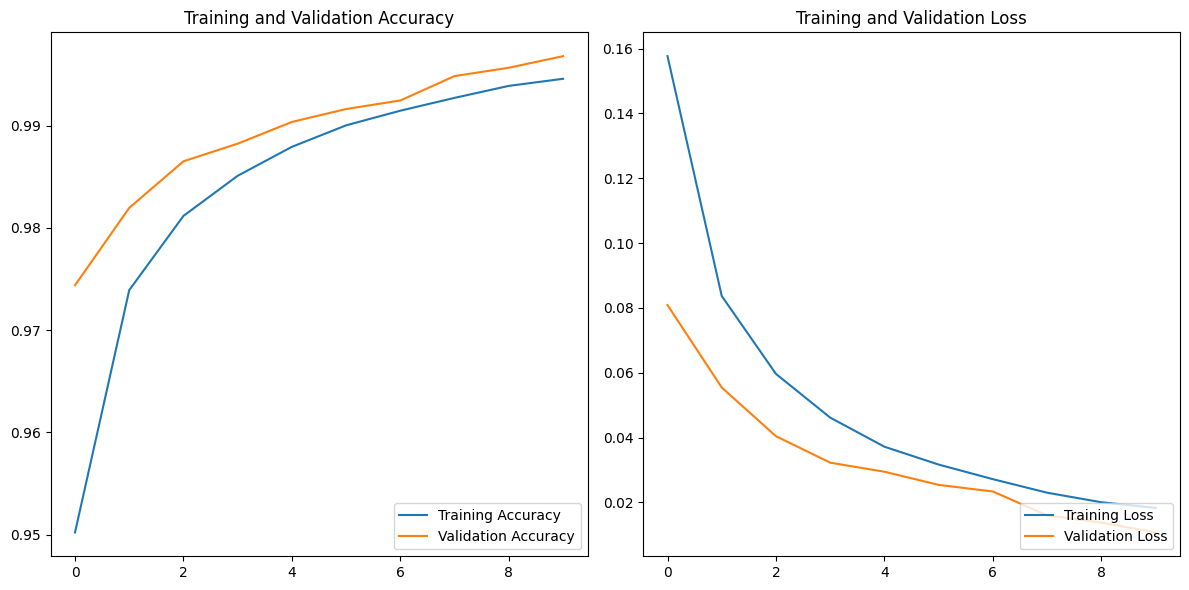

In [25]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_10 = Sequential([
    LSTM(units=30, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    LSTM(units=30, return_sequences=False),
    Dropout(0.2),
    Dense(units=15, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')  
])

model_10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_10.summary()

model_10.save('../models/model_10/model_10_h28.keras')

start_time = time.time()

history_28 = model_10.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_10/history_28.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_28.history, file)


loss, accuracy = model_10.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_28)

---

### **Janela Temporal = 30**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 30)         │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,053 (50.99 KB)

 Trainable params: 13,023 (50.87 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.9072 - loss: 0.2589 - val_accuracy: 0.9723 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 3528s 333ms/step - accuracy: 0.9730 - loss: 0.0863 - val_accuracy: 0.9773 - val_loss: 0.0666 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.9803 - loss: 0.0616 - val_accuracy: 0.9869 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.9855 - loss: 0.0449 - val_accuracy: 0.9906 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - accuracy: 0.9884 - loss: 0.0372 - val_accuracy: 0.9901 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.9905 - loss: 0.0308 - val_accuracy: 0.9915 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/st

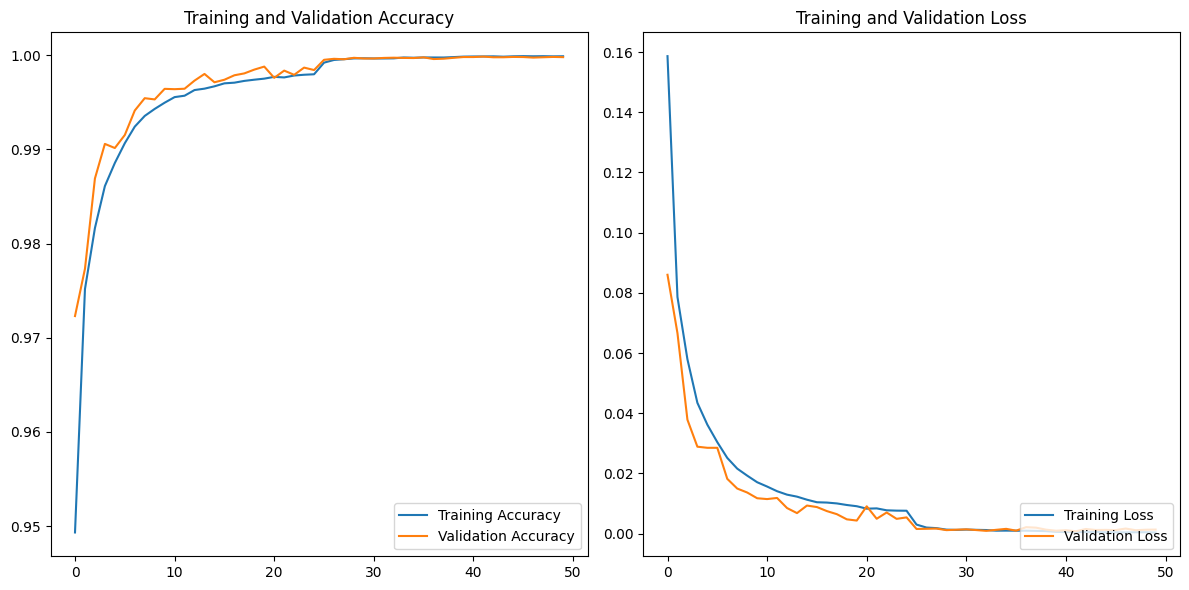

In [20]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_10 = Sequential([
    LSTM(units=30, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    LSTM(units=30, return_sequences=False),
    Dropout(0.2),
    Dense(units=15, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')  
])

model_10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_10.summary()

model_10.save('../models/model_10/model_10_h29.keras')

start_time = time.time()

history_29 = model_10.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_10/history_29.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_29.history, file)


loss, accuracy = model_10.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_29)

---

### **Janela Temporal = 50**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 30)         │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,053 (50.99 KB)

 Trainable params: 13,023 (50.87 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 256s 24ms/step - accuracy: 0.9229 - loss: 0.2195 - val_accuracy: 0.9824 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 266s 25ms/step - accuracy: 0.9831 - loss: 0.0541 - val_accuracy: 0.9908 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 252s 24ms/step - accuracy: 0.9901 - loss: 0.0331 - val_accuracy: 0.9923 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 264s 25ms/step - accuracy: 0.9932 - loss: 0.0233 - val_accuracy: 0.9970 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 265s 25ms/step - accuracy: 0.9953 - loss: 0.0168 - val_accuracy: 0.9962 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 264s 25ms/step - accuracy: 0.9962 - loss: 0.0127 - val_accuracy: 0.9978 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 27

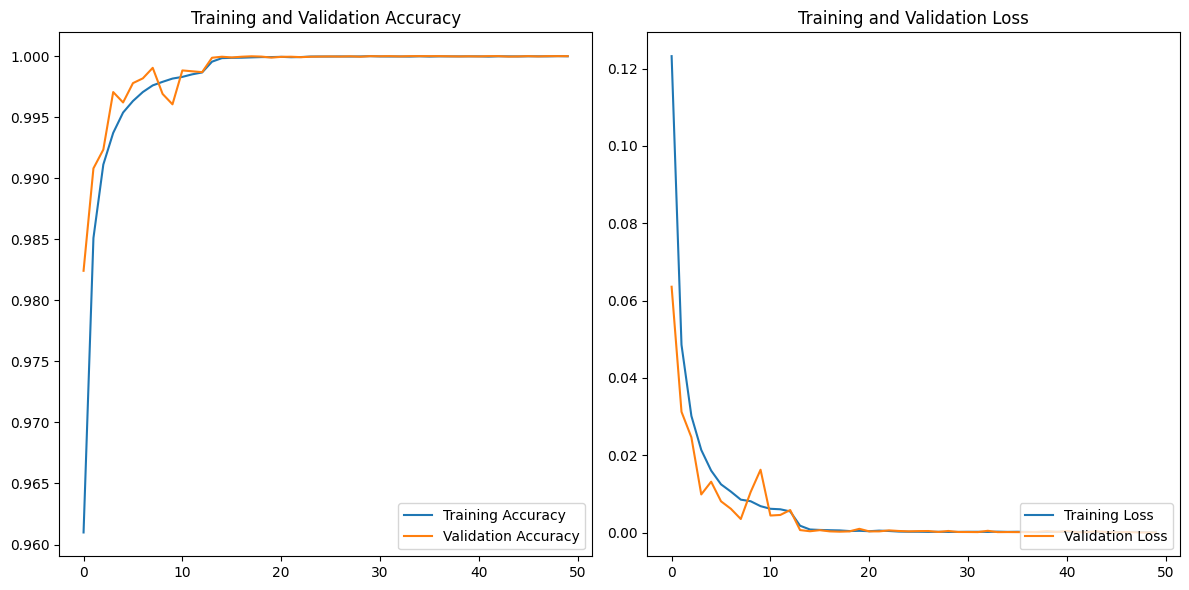

In [10]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_10 = Sequential([
    LSTM(units=30, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    LSTM(units=30, return_sequences=False),
    Dropout(0.2),
    Dense(units=15, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')  
])

model_10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_10.summary()

model_10.save('../models/model_10/model_10_h29.keras')

start_time = time.time()

history_30 = model_10.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_10/history_30.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_30.history, file)


loss, accuracy = model_10.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_30)

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 11</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 20, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,371 (353.01 KB)

 Trainable params: 90,243 (352.51 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 188s 17ms/step - accuracy: 0.9048 - loss: 0.2648 - val_accuracy: 0.9703 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 185s 17ms/step - accuracy: 0.9704 - loss: 0.0939 - val_accuracy: 0.9773 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 3/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 195s 18ms/step - accuracy: 0.9793 - loss: 0.0653 - val_accuracy: 0.9863 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 4/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 197s 19ms/step - accuracy: 0.9853 - loss: 0.0471 - val_accuracy: 0.9884 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 5/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 204s 19ms/step - accuracy: 0.9883 - loss: 0.0365 - val_accuracy: 0.9925 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 6/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 247s 18ms/step - accuracy: 0.9909 - loss: 0.0289 - val_accuracy: 0.9933 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 7/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 19

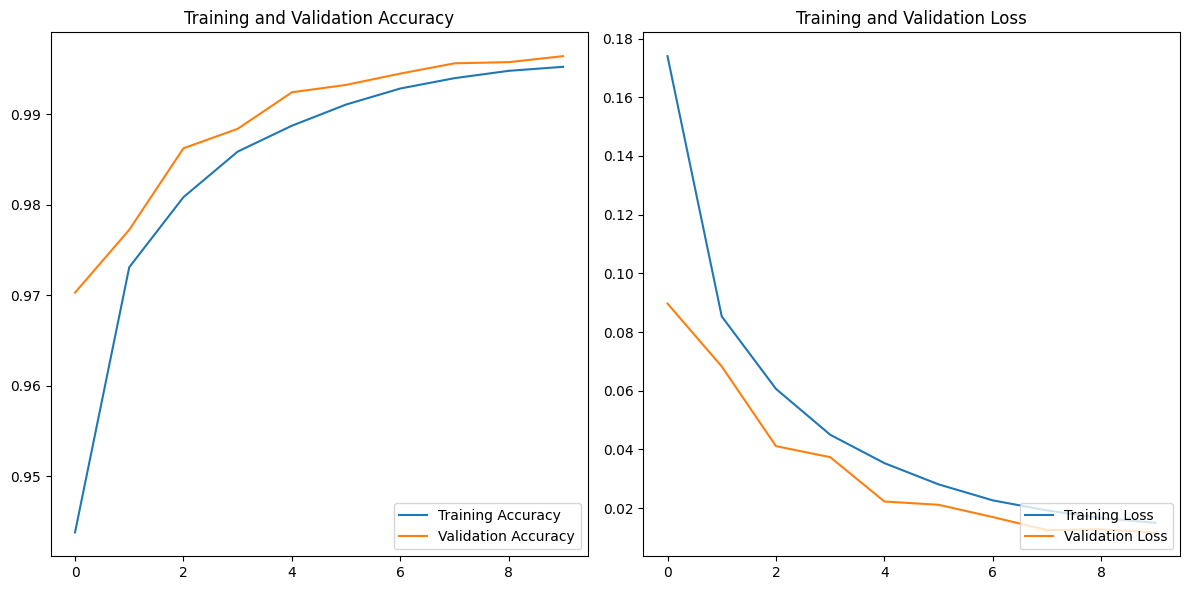

In [22]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_11 = Sequential([
    LSTM(units=64, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')
])

model_11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_11.summary()

model_11.save('../models/model_11/model_11_h31.keras')

start_time = time.time()

history_31 = model_11.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_11/history_31.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_31.history, file)


loss, accuracy = model_11.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_31)


---

### **Janela Temporal = 30**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,371 (353.01 KB)

 Trainable params: 90,243 (352.51 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 308s 28ms/step - accuracy: 0.9260 - loss: 0.2147 - val_accuracy: 0.9799 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 2/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 340s 32ms/step - accuracy: 0.9791 - loss: 0.0646 - val_accuracy: 0.9878 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 3/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 245s 23ms/step - accuracy: 0.9878 - loss: 0.0371 - val_accuracy: 0.9926 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 4/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 244s 23ms/step - accuracy: 0.9918 - loss: 0.0254 - val_accuracy: 0.9950 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 5/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 305s 29ms/step - accuracy: 0.9945 - loss: 0.0176 - val_accuracy: 0.9959 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 6/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 260s 25ms/step - accuracy: 0.9960 - loss: 0.0136 - val_accuracy: 0.9969 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 26

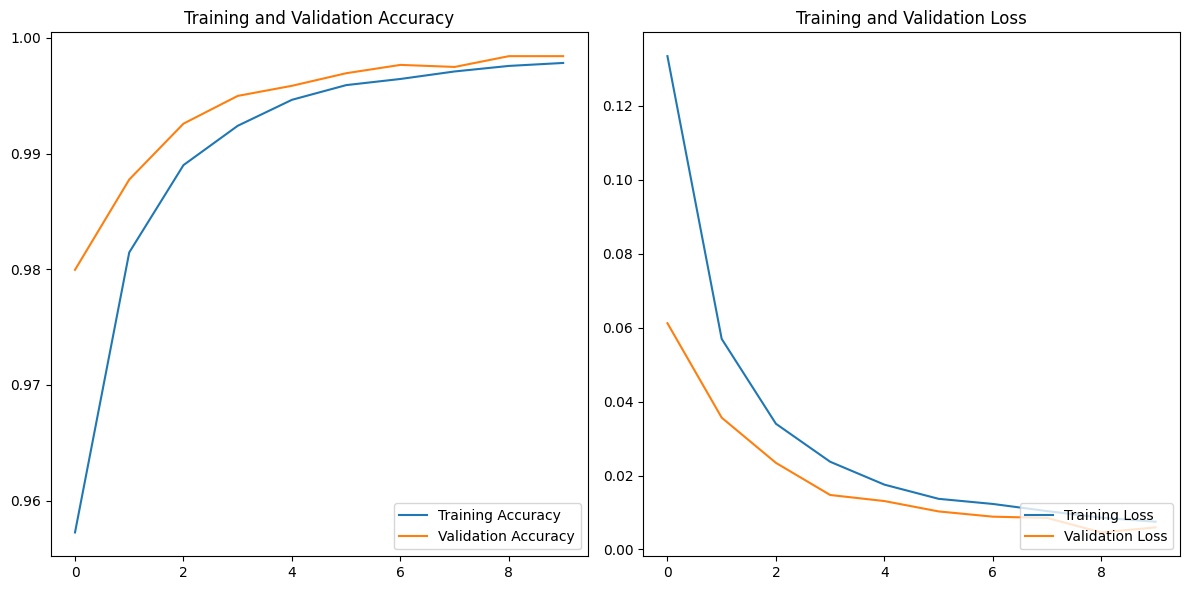

In [23]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_11 = Sequential([
    LSTM(units=64, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')
])

model_11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_11.summary()

model_11.save('../models/model_11/model_11_h32.keras')

start_time = time.time()

history_32 = model_11.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_11/history_32.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_32.history, file)


loss, accuracy = model_11.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_32)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 50, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,371 (353.01 KB)

 Trainable params: 90,243 (352.51 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 422s 39ms/step - accuracy: 0.9378 - loss: 0.1807 - val_accuracy: 0.9857 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 2/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 432s 41ms/step - accuracy: 0.9884 - loss: 0.0385 - val_accuracy: 0.9903 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 3/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 448s 42ms/step - accuracy: 0.9938 - loss: 0.0211 - val_accuracy: 0.9965 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 4/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 344s 33ms/step - accuracy: 0.9963 - loss: 0.0133 - val_accuracy: 0.9956 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 5/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 297s 28ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9991 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 292s 28ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9991 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/30
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 32

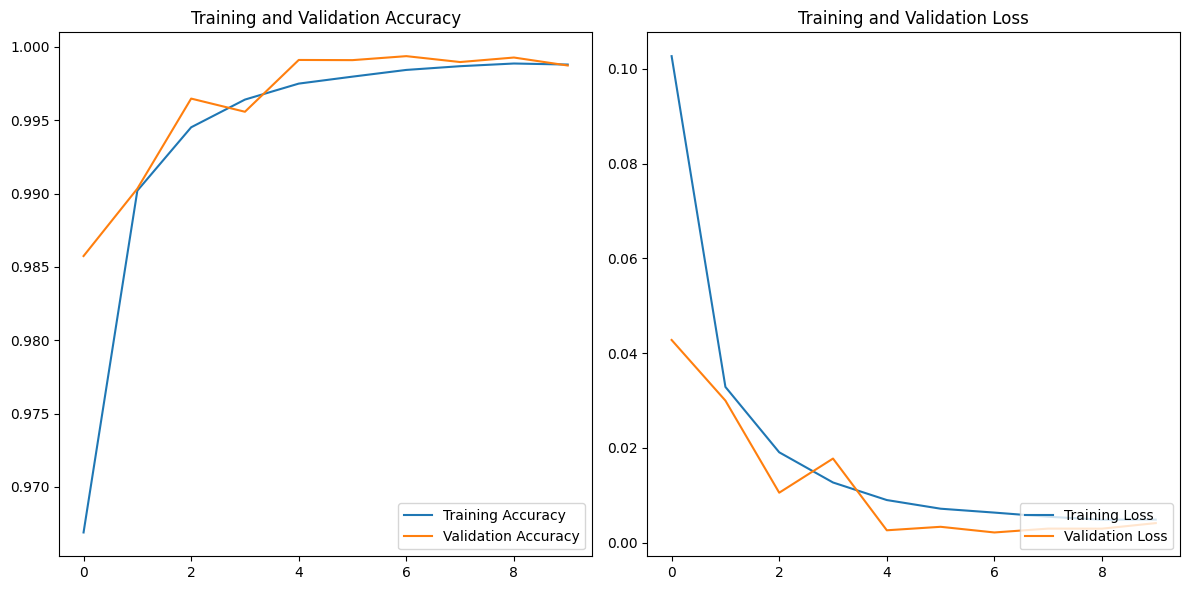

In [24]:
WINDOW_LENGTH = 50
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

model_11 = Sequential([
    LSTM(units=64, input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=NUM_CLASSES, activation='softmax')
])

model_11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_11.summary()

model_11.save('../models/model_11/model_11_h33.keras')

start_time = time.time()

history_33 = model_11.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_11/history_33.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_33.history, file)


loss, accuracy = model_11.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_33)
